# El problema del péndulo invertido

En esta guía se le pide implementar el sistema de control difuso para el problema del péndulo invertido. Para ello será necesario establecer las funciones de pertenencia de las entradas y de las salidas. Además debe definir las reglas para que el sistema efectúe el control.

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*show.*")
%matplotlib inline

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## Funciones de pertenencia

Implementar las funciones de pertenencia para este problema según fueron estudiadas del libro Passino & Yurkovich (1997). A continuación se copia la imagen de las mismas tomada del libro mencionado. Como ayuda se proveen algunos conjuntos de ejemplo para cada variable, lo cual debe completarse con todos los valores lingüísticos. Puede comparar la visualización de los conjuntos de ejemplo con la imagen del libro.

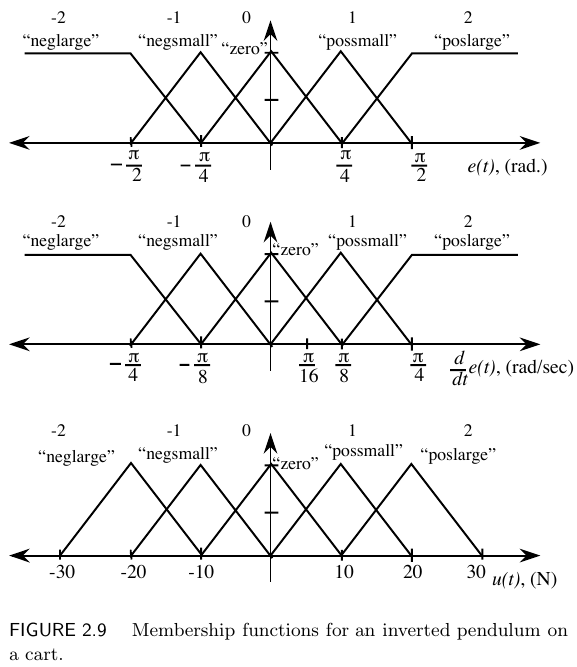

In [4]:
# Se define el universo de discurso para la variable lingüística angerror, varerror, force
# Se establecen como Antecedente y Consecuentes del problema.

# El universo de discurso para cada variable se define con un arange de numpy mediante
# tres valores: inicio del universo, fin del universo, salto en ese universo.
angerror = ctrl.Antecedent(np.arange(-np.pi, np.pi, np.pi/60), 'angerror')
varerror = ctrl.Antecedent(np.arange(-np.pi/2, np.pi/2, np.pi/48), 'varerror')
force = ctrl.Consequent(np.arange(-30, 31, 1), 'force')

# Conjuntos borrosos para el error angular
angerror["0"] = fuzz.trimf(angerror.universe, [-np.pi/4, 0, np.pi/4])
angerror["+1"] = fuzz.trimf(angerror.universe, [0, np.pi/4, np.pi/2])
#
# COMPLETAR
#

# Conjuntos borrosos para la variación del error angular
varerror["+2"] = fuzz.trapmf(varerror.universe, [np.pi/8, np.pi/4, np.pi/2, np.pi/2])
#
# COMPLETAR
#

# Conjuntos borrosos para la fuerza (variable de salida)
force["-2"] = fuzz.trimf(force.universe, [-30, -20, -10])
#
# COMPLETAR
#

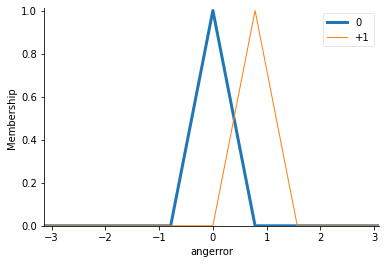

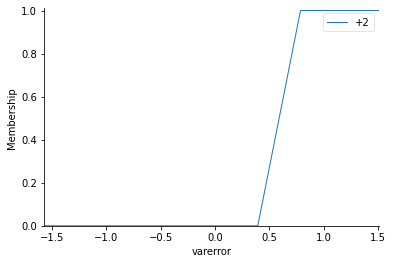

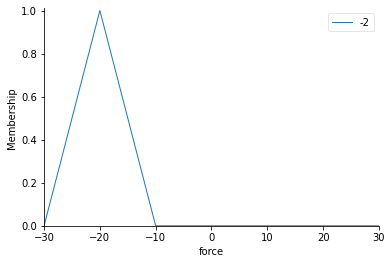

In [19]:
# Graficación para verificar la respuesta
angerror["0"].view()
varerror.view()
force.view()

## Reglas

Implementar las reglas del sistema de control para este problema según fueron estudiadas del libro Passino & Yurkovich (1997). A continuación se copia la matriz que resume las reglas, tomada del libro mencionado. Como ayuda se proveen dos reglas de ejemplo.

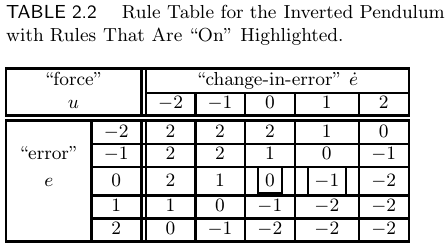

In [20]:
inv_pend_ctrl = ctrl.ControlSystem([
    ctrl.Rule(angerror['0'] & varerror['+2'], force['-2']),
    ctrl.Rule(angerror['+1'] & varerror['+2'], force['-2']),
    #
    # COMPLETAR
    #
])

## Ejemplo simple al utilizar el controlador

Aquí se da un ejemplo muy simple al utilizar el controlador, sólo a fines ilustrativos. Luego veremos de embeber esta operación dentro de la simulación del problema del control del péndulo invertido.

In [28]:
# Definidas los antecedentes, consecuentes y reglas, se instancia el controlador
# a quien le podemos pasar las entradas numéricas y pedir que compute una salida

inv_pend = ctrl.ControlSystemSimulation(inv_pend_ctrl)

# Las entradas se pueden dar en un diccionario de python {nombre_var: valor}
inv_pend.inputs({
    "angerror": -10 * np.pi / 180,  # Error de -10º
    "varerror": +27 *np.pi / 180    # Cambio de error de +27º/segundo
})
inv_pend.compute()
inv_pend.output["force"]

-19.999999999999996

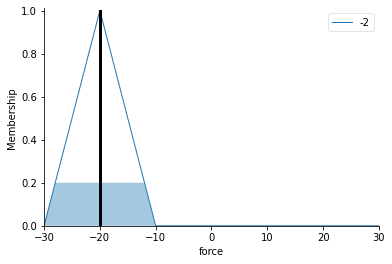

In [29]:
# Visualización de los conjuntos implicados y defuzzyficación
force.view(sim=inv_pend)

---
# Creando el escenario físico simulado para utilizar el controlador definido.

En principio vamos a utilizar el problema definido en `gym` como `"CartPole-v1"`. Luego trabajaremos con una versión modificada.

Una vez definido el sistema en los pasos anteriores, pruebe el controlador para la referencia en 0º. Luego pruebe modificarla. ¿Qué comportamiento observa?

In [45]:
import gym
import time

# Se crea el escenario de simulación
cart_gym = gym.make('CartPole-v1')

# Angulo de referencia al cual pretendemos que el controlador mantenga el pendulo
ang_ref = 0 * (np.pi / 180)  

# Para conocer un poco más del entorno podemos ver la ayuda
cart_gym.env?

Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v1>>
File:        ~/.virtualenvs/inteligencia-computacional/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.

Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson

Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

Actions:
    Type: Discrete(2)
    Num   Action
  

In [37]:
# Preguntamos sobre la acción y los datos que nos suministra el sistema
print("Cuál es la acción posible en este problema?\n", cart_gym.action_space)
print("\nQué datos puedo leer de este sistema?\n", cart_gym.observation_space)

Cuál es la acción posible en este problema?
 Discrete(2)

Qué datos puedo leer de este sistema?
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
# Máximo tiempo de la simulación
max_t = 100
# Máxima cantidad de episodios/repeticiones de la simulación
max_episodes = 1  

for i_episode in range(max_episodes):
    observation = cart_gym.reset()
    
    for t in range(max_t):
        cart_gym.render()
        
        # Tomo los datos de los sensores del vehiculo y el problema
        car_pos, car_vel, pole_ang, pole_vel = observation

        # Calculo las entradas al sistema de control difuso
        angerror_t = ang_ref - pole_ang
        varerror_t = - pole_vel
              
        print(f"En t = {t}: angerror = {angerror_t:.4f} y varerror = {varerror_t:0.4f}")
        
        # Ingreso al controlador difuso los valores numericos de las entradas
        inv_pend.inputs({
            "angerror": angerror_t,
            "varerror": varerror_t
        })
        # computo la acción
        inv_pend.compute()
        # Tomo el valor numerico de la fuerza de salida
        force_t = inv_pend.output["force"]
        
        print(f"\t  Fuerza = {force_t:0.4f}")
        
        # El modelo del carrito acepta 0 (fuerza a izquierda) o 1 (fuerza a derecha)
        # Si la fuerza del controlador force_t es positiva entonces envío 1 al simulador
        # Si la fuerza es negativa force_t es cero o negativa entonces envío 0 al simulador
        action = int(force_t > 0)
        observation, reward, done, info = cart_gym.step(action)
        if done:
            print("Episodio finalizado luego de {} instantes de tiempo".format(t+1))
            break
            
        time.sleep(0.1)
    time.sleep(0.1)
            
cart_gym.close()

---
# Creando otro escenario físico simulado para utilizar el controlador definido.


Ahora vamos a utilizar un problema similar al `"CartPole-v1"`. Esta reversión acepta entradas continuas en un rango de fuerzas mayor.
También tiene menos limitaciones en el ángulo posible del péndulo. Necesita del archivo `cartpole_tuar.py` en la misma carpeta que esta notebook.

Pruebe el mismo controlador que antes, ahora en este problema. Al igual que antes la referencia está definida en 0º. Luego pruebe modificarla. ¿Qué comportamiento observa? ¿Cómo se compara con la situación anterior donde la acción era discreta?

In [ ]:
import cartpole_tuar

gym.register(
    id='CartPole-v100',
    entry_point=cartpole_tuar.CartPoleEnv,
    max_episode_steps=500,
    reward_threshold=475.0,
)

In [53]:
cart_TUAR = gym.make('CartPole-v100')

# Angulo de referencia al cual pretendemos que el controlador mantenga el pendulo
ang_ref = 0 * (np.pi / 180)  

# Para conocer un poco más del entorno podemos ver la ayuda
cart_TUAR.env?

Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v100>>
File:        ~/projects/inteligencia-computacional/fuzzylogic/cartpole_tuar.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.

Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson

Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

Actions:
    Type: Box(1)
    Num     Action                    Min                     M

In [52]:
# Preguntamos sobre la acción y los datos que nos suministra el sistema
print("Cuál es la acción posible en este problema?\n", cart_TUAR.action_space)
print("\nQué datos puedo leer de este sistema?\n", cart_TUAR.observation_space)

Cuál es la acción posible en este problema?
 Box(-20.0, 20.0, (1,), float32)

Qué datos puedo leer de este sistema?
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
# Máximo tiempo de la simulación
max_t = 100
# Máxima cantidad de episodios/repeticiones de la simulación
max_episodes = 1

for i_episode in range(max_episodes):
    observation = cart_TUAR.reset()
    
    for t in range(max_t):
        cart_TUAR.render()
        
        # Tomo los datos de los sensores del vehiculo y el problema
        car_pos, car_vel, pole_ang, pole_vel = observation

        # Calculo las entradas al sistema de control difuso
        angerror_t = ang_ref - pole_ang
        varerror_t = - pole_vel
              
        print(f"En t = {t}: angerror = {angerror_t:.4f} y varerror = {varerror_t:0.4f}")
        
        # Ingreso al controlador difuso los valores numericos de las entradas
        inv_pend.inputs({
            "angerror": angerror_t,
            "varerror": varerror_t
        })
        # computo la acción
        inv_pend.compute()
        # Tomo el valor numerico de la fuerza de salida
        force_t = inv_pend.output["force"]
        
        print(f"\t  Fuerza = {force_t:0.4f}")
        
        # El modelo del carrito acepta una lista con un solo elemento
        # dicho elemento es un float entre -20 y 20
        action = [force_t]
        observation, reward, done, info = cart_TUAR.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
            
        time.sleep(0.1)
    time.sleep(0.1)
            
cart_TUAR.close()

# Comentarios finales

La construcción del sistema para este escenario se debe pensar como un escenario simple que permite explorar las distintas partes del controlador y del simulador del fenómeno físico. Es recomendable que además de completar las reglas y funciones de pertenencia dadas por el libro, también explore el funcionamiento construyendo un nuevo controlador con reglas y/o funciones de pertenencia modificadas. Observe que sucede ante estas modificaciones.